### Step one: Importing necessary packages

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import scipy.stats as stats

warnings.filterwarnings("ignore")

### Step two: Load dataset / EDA

In [2]:
df = pd.read_csv(r"cookie_cats.csv")
df.sample(4)

,userid,version,sum_gamerounds,retention_1,retention_7
11414,1260545,gate_40,63,False,True
28173,3138042,gate_30,205,True,True
497,51641,gate_40,20,True,False
56382,6246671,gate_40,8,False,False


In [3]:
df.shape                                # Check the number of records and attributes contained in the dataset
df.isnull().sum().sum()                 # Check the number of null values

print(f"There are {df.shape[0]} records and {df.shape[1]} attributes in the dataset")
print('')
print(f"There are {df.isnull().sum().sum()} null values in the dataset")

There are 90189 records and 5 attributes in the dataset

There are 0 null values in the dataset


The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

1. userid - a unique number that identifies each player.
2. version - whether the player was put in the control group (gate_30 - a gate at level 30)
or the test group (gate_40 - a gate at level 40).
3. sum_gamerounds - the number of game rounds played by the player during the first week after installation
4. retention_1 - did the player come back and play 1 day after installing?
5. retention_7 - did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

In [4]:
# Number of Unique User

print(df.userid.nunique())

90189


In [5]:
# Summary Stats: sum_gamerounds

df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [6]:
# A/B Groups & Target Summary Stats

df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854
gate_40,45489,16.0,51.298776,103.294416,2640


In [7]:
# Drop users who did not play the game at all

dff = df[df['sum_gamerounds']>0]

sum_gamerounds    Axes(0.125,0.11;0.775x0.77)
dtype: object

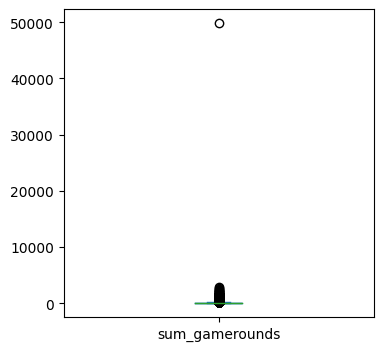

In [8]:
#Checking for outliers using Boxplots

dff['sum_gamerounds'].plot(
    kind = 'box',
    figsize = (4,4),
    subplots = True
)

(76494, 5)


sum_gamerounds    Axes(0.125,0.11;0.775x0.77)
dtype: object

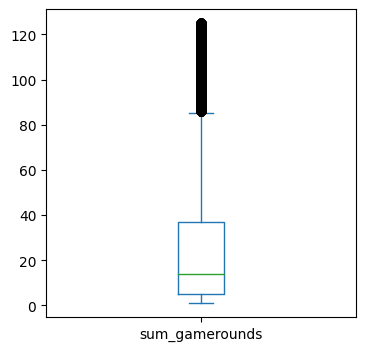

In [9]:
# Remove extreme outliers so that this doesnot affect our A/B Testing

upper_limit = dff.sum_gamerounds.quantile(0.75) + (1.5*(dff.sum_gamerounds.quantile(0.75) - dff.sum_gamerounds.quantile(0.25)))

df0 = dff[dff['sum_gamerounds'] < upper_limit]
print(df0.shape)

df0['sum_gamerounds'].plot(
    kind = 'box',
    figsize = (4,4),
    subplots = True
)

(71520, 5)


sum_gamerounds    Axes(0.125,0.11;0.775x0.77)
dtype: object

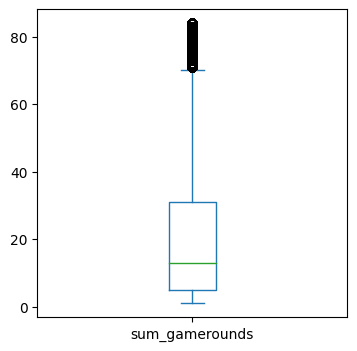

In [10]:
# Remove extra outliers

upper_limit = df0.sum_gamerounds.quantile(0.75) + (1.5*(df0.sum_gamerounds.quantile(0.75) - df0.sum_gamerounds.quantile(0.25)))

data = df0[df0['sum_gamerounds'] < upper_limit]
print(data.shape)

data['sum_gamerounds'].plot(
    kind = 'box',
    figsize = (4,4),
    subplots = True
)

In [11]:
data['sum_gamerounds'].describe()

count    71520.000000
mean        20.471211
std         20.498226
min          1.000000
25%          5.000000
50%         13.000000
75%         31.000000
max         84.000000
Name: sum_gamerounds, dtype: float64

In [12]:
# Retention Problem
pd.DataFrame({"RET1_COUNT": data["retention_1"].value_counts(),
              "RET7_COUNT": data["retention_7"].value_counts(),
              "RET1_RATIO": data["retention_1"].value_counts() / len(data),
              "RET7_RATIO": data["retention_7"].value_counts() / len(data)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,44550,64606,0.622903,0.903328
True,26970,6914,0.377097,0.096672



Looking at the summary statistics of retention variables by version and comparing with sum_gamerounds,
there are similarities between groups.

However, it will be more helpful to see if there is a statistically significant difference.

In [13]:
print("For Retention_1:")
data.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

For Retention_1:


count  median       mean        std  max
version retention_1                                          
gate_30 False        22029     7.0  12.566435  14.769487   84
        True         13536    30.0  33.731161  21.482943   84
gate_40 False        22521     7.0  12.368678  14.728065   84
        True         13434    29.0  33.656022  22.070965   84

In [14]:
print("For Retention_7 :")
data.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

For Retention_7 :


count  median       mean        std  max
version retention_7                                          
gate_30 False        31951    11.0  18.130074  18.561480   84
        True          3614    42.0  42.649972  22.614351   84
gate_40 False        32655    11.0  18.097412  18.908127   84
        True          3300    42.0  42.339091  23.397157   84

### Step three: A\B Testing

Steps:

i. Define Control Group & Test Group

ii. Check normality
Apply Shapiro Test for normality
    If Distributionis normal,

iii. Check homogeneity
Apply Levene Test for homogeneity of variances
    If Parametric + homogeneity of variances apply T-Test
    If Parametric - homogeneity of variances apply Welch Test

iv.If Non-parametric apply Mann Whitney U Test directly

In [15]:
# Define A/B groups

data["group"] = np.where(data.version == "gate_30", "control_group", "test_group")
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7,group
0,116,gate_30,3,False,False,control_group
1,337,gate_30,38,True,False,control_group
3,483,gate_40,1,False,False,test_group
7,1444,gate_40,2,False,False,test_group
10,1842,gate_40,3,False,True,test_group


<Axes: ylabel='Frequency'>

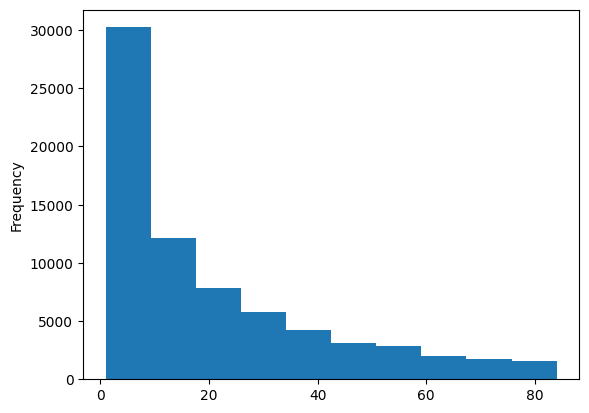

In [16]:
# Plot a histogram to check for normality

data['sum_gamerounds'].plot(kind="hist")

In [17]:
# Test for Normality using Shapiro-Wilk Test
# If pvalue is greater than 0.05, then the dataset is normally distributed

from scipy.stats import shapiro
import scipy.stats as stats

# Split A/B
groupA = data[data["group"] == "control_group"]["sum_gamerounds"]
groupB = data[data["group"] == "test_group"]["sum_gamerounds"]

ntA = shapiro(groupA)[1] < 0.05
ntB = shapiro(groupB)[1] < 0.05

print(shapiro(groupA))
print(shapiro(groupB))


ShapiroResult(statistic=0.8437244296073914, pvalue=0.0)
ShapiroResult(statistic=0.8320155143737793, pvalue=0.0)


In [18]:
# Mann-Whitney U Test for A/B Testing
# Given that the dataset is non-parametric, we apply Mann-Whitney Test

ttest = stats.mannwhitneyu(groupA, groupB)

"""
H0: A == B i.e The Null hypothesis postulates that the two groups are similar
H1: A != B i.e The Alternate hypothesis states that the two groups are disimilar

A p-value of greater than 0.05 indicates that there is no statistically significant difference between the two groups.
Thus, we accept the Null Hypothesis
"""

print(ttest)

MannwhitneyuResult(statistic=648066712.5, pvalue=0.0016191181876004466)


In [19]:
if ttest[1] < 0.05:
    print("Reject H0")
    print("The test and control groups are disimilar")
else:
    print("Fail to Reject H0")
    print("The test and control groups are similar")

Reject H0
The test and control groups are disimilar


In [20]:
# A/B Testing Function

def AB_Test(dataframe, group, target):

    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats

    # Split A/B
    groupA = dataframe[dataframe[group] == "control_group"][target]
    groupB = dataframe[dataframe[group] == "test_group"][target]

    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True

    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True

        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1]
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True

    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05],
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")

    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]

    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")

    return temp



# Apply A/B Testing
AB_Test(dataframe=data, group = "group", target = "sum_gamerounds")


# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.001619,A/B groups are not similar!


### Step four: Conclusion


As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40.

After applying A/B Testing, the analysis result gives us some important information.
Apply Shapiro Testing - for Normality assumption.
    Levene Test       - for Homogenity
    if normal and homogenity is True - Ttest
    if normal and homogenity is False- Welch test
    
However if Non-parametric (i.e not normal) - Mann Whitney U test.

For our dataset,
Mann Whitney U Testing failed to reject H0 hypothesis and we learned A/B groups are disimilar!

Thus putting the gate at either level 40 or level 30 will give different results.